In [ ]:
#This is the python code for running the initial CNN model with 4 convolutional layers. 

In [ ]:
#The processed training and test images dataset can be downloaded from the following URL
#https://alabama.box.com/s/u18t3z0kahgpedgva1h06eikkb6nocr4

In [ ]:
#Download the zip files from the following link

In [ ]:
#Training images

!wget https://alabama.box.com/s/isylwsjb5wphq0owgjl1hx12xad81w2a

In [ ]:
!gzip -d Training_0.2.zip

In [ ]:
#Test images

!wget https://alabama.box.com/s/254plk0zo7uez06gvn1kjbqfb0li2brf

In [ ]:
!gzip -d Test_0.2.zip

In [30]:
import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from tensorflow import image
import tensorflow as tf
import pandas as pd

from keras.initializers import TruncatedNormal, RandomUniform
from keras import regularizers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.constraints import max_norm
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import Normalizer, StandardScaler

In [31]:
#This defines the image path

IMAGE_PATH = "/Users/adityaupreti/Desktop/PH582ML2021/FinalProject/Images/Training_0.2/"
file_paths = glob.glob(path.join(IMAGE_PATH, '*.png'))

# The images are loaded into a single variable and convert to a numpy array
images = [imageio.imread(path) for path in file_paths]
images = np.asarray(images)
print(images.shape)

image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])
print(image_size)

# this is done to scale images so values are between 0 and 1
images = images / 255


(13502, 200, 200, 4)
[200 200   4]


In [32]:
images.shape

(13502, 200, 200, 4)

In [33]:
#from tensorflow import image

In [ ]:
images = image.resize(
    images, [100,100], method='bilinear', preserve_aspect_ratio=False,
    antialias=False, name=None).numpy()

In [ ]:
image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])
print(image_size)

In [4]:
# Read the labels from the filenames

n_images = images.shape[0]
labels = np.zeros(n_images)
for i in range(n_images):
    filename = path.basename(file_paths[i])[0]
    if filename[0] == 'W':                          #Every file that begins with W is assigned a 1
        labels[i] = 1
    else:
        labels[i] = 0

# Background = 0 = FALSE
# WIMPS = 1 = TRUE


In [6]:
# Split into test and training sets

TRAIN_TEST_SPLIT = 0.7           

# Split at the given index
split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

# Split the images and the labels
x_train = images[train_indices, :, :, :]
y_train = labels[train_indices]
x_val = images[test_indices, :, :, :]
y_val = labels[test_indices]

In [12]:
shape = (image_size[0], image_size[1], image_size[2])
lr_init     = 1.e-3    # Initial learning rate
model = Sequential()
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal', input_shape=shape))
model.add(BatchNormalization())
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(BatchNormalization())
model.add(Conv2D(64, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 100, 100, 32)      1184      
_________________________________________________________________
batch_normalization_12 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
batch_normalization_13 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 64)       

In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
early_stopping_cb = EarlyStopping(monitor='loss', patience=5)
history=model.fit(x_train, y_train,\
        batch_size=100,\
        epochs=40,\
        validation_data=(x_val, y_val),\
        callbacks=[reduce_lr, early_stopping_cb],\
        verbose=1, shuffle=True)

Epoch 1/40
70/70 [==============================] - 41s 578ms/step - loss: 0.5010 - accuracy: 0.7491 - precision: 0.7337 - recall: 0.7583 - val_loss: 1.8616 - val_accuracy: 0.5070 - val_precision: 0.5070 - val_recall: 1.0000
Epoch 2/40
70/70 [==============================] - 37s 531ms/step - loss: 0.3720 - accuracy: 0.8325 - precision: 0.8137 - recall: 0.8574 - val_loss: 3.2922 - val_accuracy: 0.5070 - val_precision: 0.5070 - val_recall: 1.0000
Epoch 3/40
70/70 [==============================] - 37s 531ms/step - loss: 0.3230 - accuracy: 0.8554 - precision: 0.8449 - recall: 0.8710 - val_loss: 2.7900 - val_accuracy: 0.5070 - val_precision: 0.5070 - val_recall: 1.0000
Epoch 4/40
70/70 [==============================] - 37s 534ms/step - loss: 0.3088 - accuracy: 0.8647 - precision: 0.8601 - recall: 0.8733 - val_loss: 4.1181 - val_accuracy: 0.5070 - val_precision: 0.5070 - val_recall: 1.0000
Epoch 5/40
70/70 [==============================] - 37s 533ms/step - loss: 0.2855 - accuracy: 0.8790

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as img 
from matplotlib import ticker, cm
import matplotlib as mpl
import matplotlib.patches as patches
%matplotlib inline
import math
import scipy.integrate as integrate

from mpl_toolkits.mplot3d import axes3d

In [14]:
#Saving the trained model and its weights

model.save('CNNmodel_XENON.h5')

In [2]:
from sklearn.metrics import roc_curve, auc
from keras.models import load_model

model = load_model('CNNmodel_XENON.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 100, 100, 32)      1184      
_________________________________________________________________
batch_normalization_12 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
batch_normalization_13 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 64)       

In [18]:
from keras.models import load_model
from keras import backend as K
np.random.seed(0)
from sklearn import metrics
    
IMAGE_PATH = '/Users/adityaupreti/Desktop/PH582ML2021/FinalProject/Images/Test_0.2'
file_paths = glob.glob(path.join(IMAGE_PATH, '*.png'))

# Load the images into a single variable and convert to a numpy array 
images = [imageio.imread(path) for path in file_paths]
images = np.asarray(images)

image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])
print(image_size)

images = image.resize(
    images, [100,100], method='bilinear', preserve_aspect_ratio=False,
    antialias=False, name=None
).numpy()

print(image_size)

# Scale images so values are between 0 and 1 
images = images / 255

n_images = images.shape[0]
labels = np.zeros(n_images)
for i in range(n_images):
    filename = path.basename(file_paths[i])[0]
    if filename[0] == 'W':            #Every file that begins with W is assigned a 1
        labels[i] = 1
    elif filename[0] == 'E':
        labels[i] = 0

x_test = images
y_test = labels
y_test = np.asarray(y_test)

[200 200   4]
[200 200   4]


In [19]:
print(images.shape)

(5442, 100, 100, 4)


In [29]:
# Evaluate on test set
from sklearn import metrics
score = model.evaluate(x_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(x_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

171/171 [==============================] - 9s 52ms/step - loss: 0.3446 - accuracy: 0.8548 - precision: 0.8211 - recall: 0.9432

Test loss / accuracy: 0.3446 / 0.8548
Test ROC AUC: 0.9361346474867995


In [26]:
print(y_pred)

[[0.4957267 ]
 [0.87780476]
 [0.8356443 ]
 ...
 [0.9947449 ]
 [0.99576545]
 [0.00325624]]


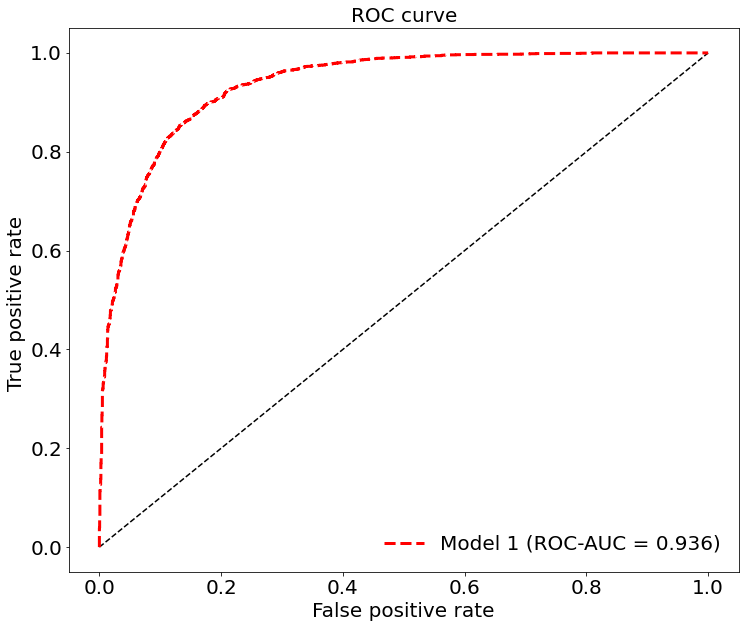

In [22]:
plt.rcParams['figure.figsize'] = [12, 10]
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc), linestyle='--',lw=3,color='red')

plt.xlabel(r'False positive rate',fontsize=20)
plt.ylabel(r'True positive rate ',fontsize=20)
plt.title(r'ROC curve',fontsize=20)
plt.legend(loc='best',numpoints = 1,frameon=False,prop={'size': 20})

plt.gca().tick_params(labelsize=20)

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]
pd.DataFrame(history.history).plot()
plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r'Metrics',fontsize=20)
plt.legend(loc='best',numpoints = 1,frameon=False,prop={'size': 20})
plt.gca().tick_params(labelsize=20)

Logistic: f1=0.878 auc=0.9426630


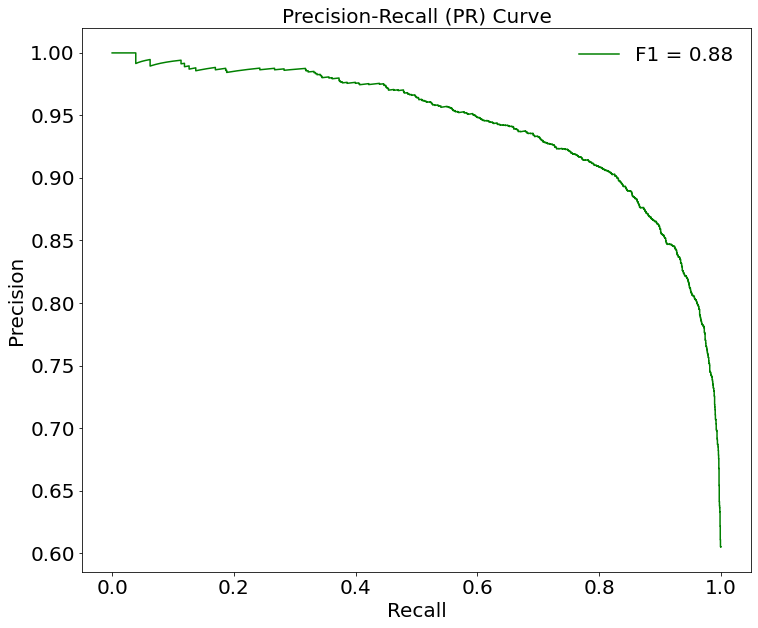

In [23]:
lr_probs = model.predict(x_test)    # Predict probabilities
yhat = model.predict(x_test)      # Predict class values
yhat = np.round(yhat)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1 = f1_score(y_test, yhat)
lr_auc = metrics.auc(lr_recall, lr_precision)

print('Logistic: f1=%.3f auc=%.7f' % (lr_f1, lr_auc))   # Summarise scores

''' plot the precision-recall curves '''
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(lr_recall, lr_precision, label='F1 = %0.2f' %(lr_f1), color='green')

plt.xlabel(r'Recall',fontsize=20)
plt.ylabel(r'Precision',fontsize=20)
plt.title(r'Precision-Recall (PR) Curve',fontsize=20)
plt.legend(loc='best',numpoints = 1,frameon=False,prop={'size': 20})

plt.gca().tick_params(labelsize=20)

Accuracy: 0.8548327820654171
Average precision: 0.8059686292814007
recall: 0.943245934284766
AUC:0.8979090810842528
Predicted   0.0   1.0
Actual               
0.0        1810   619
1.0         171  2842


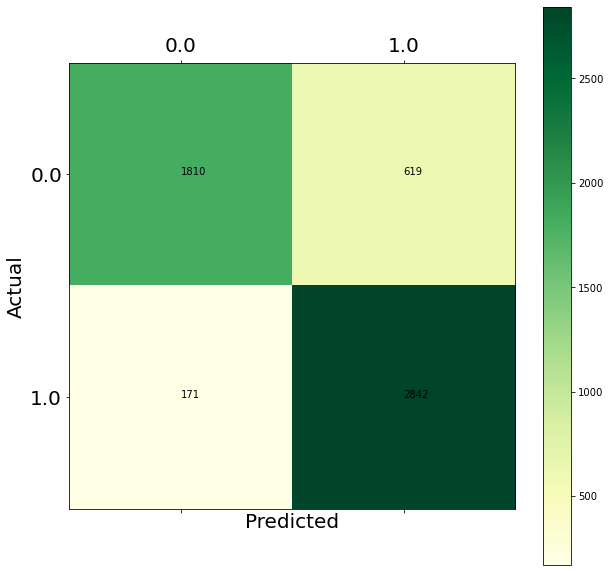

In [24]:
test_predictions = yhat             # Make a prediction on the test set
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: " + str(accuracy))
average_precision = average_precision_score(y_test, test_predictions)
print("Average precision: " + str(average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_test, test_predictions)
auc = metrics.auc(recall, precision)
recall1 = recall_score(y_test, np.round(test_predictions))
print("recall: " + str(recall1))
print('AUC:' +str(auc))


# Report Confusion Matrix
y_actu = pd.Series(y_test.ravel(), name='Actual')
y_pred = pd.Series(np.round(test_predictions.ravel()), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

# Plot confusion matrix
def plot_confusion_matrix(df_confusion, cmap='YlGn'):
    plt.rcParams['figure.figsize'] = [12, 10]

    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(0,len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, fontsize=20)
    plt.yticks(tick_marks, df_confusion.index, fontsize=20)
    plt.ylabel(df_confusion.index.name,fontsize=20)
    plt.xlabel(df_confusion.columns.name,fontsize=20)
    plt.gca().tick_params(labelsize=20)
    for i in range(len(df_confusion.index)):
        for j in range(len(df_confusion.columns)):
            plt.text(j,i,str(df_confusion.iloc[i,j]))
    plt.show()

plot_confusion_matrix(df_confusion)

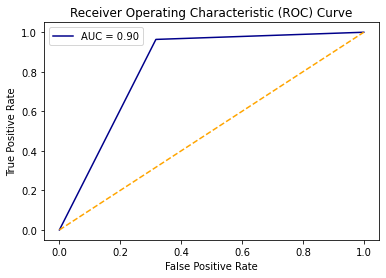

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='darkblue', label='AUC = %0.2f' %(auc))
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)
# Save tpr and fpr to plot seperate ROC curve
#np.savetxt("/content/drive/My Drive/Colab Notebooks/tpr.txt",tpr)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/fpr.txt",fpr)
plot_roc_curve(fpr, tpr)

In [28]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [29]:
import visualkeras

In [30]:
visualkeras.layered_view(model).show() # display using your system viewer

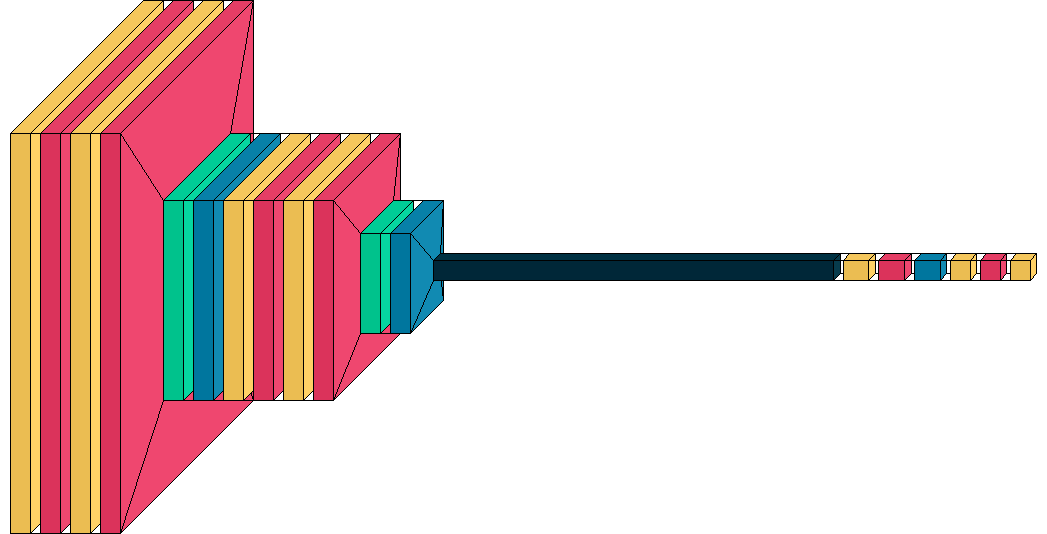

In [32]:
visualkeras.layered_view(model, to_file='CNNmodel_output.png') # write to disk